In [13]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter


In [10]:
# Load your dataset
df = pd.read_csv("../data/processed/top_150_fantasy_reviews_cleaned_balanced.csv")

# Map 'recommendation' to sentiment labels
def map_recommendation(rec):
    if rec == 'Recommended':
        return 'positive'
    elif rec == 'Not Recommended':
        return 'negative'
    else:
        return 'neutral'

df["label_text"] = df["recommendation"].map(map_recommendation)

# Check mapping
print(df[["recommendation", "label_text"]].head())
print(df["label_text"].value_counts())


  recommendation label_text
0    Recommended   positive
1    Recommended   positive
2    Recommended   positive
3    Recommended   positive
4    Recommended   positive
label_text
positive    2319
neutral     1405
negative    1136
Name: count, dtype: int64


In [11]:
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["label_text"])
print(label_encoder.classes_)  # ['negative' 'neutral' 'positive']


['negative' 'neutral' 'positive']


In [14]:
def build_vocab(texts, max_vocab_size=10000):
    counter = Counter()
    for text in texts:
        counter.update(text.lower().split())
    vocab = {"<PAD>": 0, "<UNK>": 1}
    for i, (word, _) in enumerate(counter.most_common(max_vocab_size - 2), start=2):
        vocab[word] = i
    return vocab

vocab = build_vocab(df["review_sentiment"])
MAX_LENGTH = 100

def tokenize(text, vocab):
    tokens = text.lower().split()
    ids = [vocab.get(token, vocab["<UNK>"]) for token in tokens]
    return ids[:MAX_LENGTH] + [vocab["<PAD>"]] * max(0, MAX_LENGTH - len(ids))


In [15]:
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, vocab):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokens = tokenize(self.texts[idx], self.vocab)
        return torch.tensor(tokens), torch.tensor(self.labels[idx])

# Split data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["review_sentiment"].tolist(), df["label"].tolist(), test_size=0.2, random_state=42
)

train_dataset = ReviewDataset(train_texts, train_labels, vocab)
test_dataset = ReviewDataset(test_texts, test_labels, vocab)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [16]:
class SimpleTransformer(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, hidden_dim, num_classes):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden_dim, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.embed(x)
        x = self.transformer(x)
        x = x.mean(dim=1)
        return self.fc(x)


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleTransformer(
    vocab_size=len(vocab),
    embed_dim=128,
    num_heads=4,
    hidden_dim=256,
    num_classes=len(label_encoder.classes_)
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

losses = []

for epoch in range(20):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    losses.append(total_loss / len(train_loader))
    print(f"Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f}")


Epoch 1 | Loss: 1.0469
Epoch 2 | Loss: 0.9342
Epoch 3 | Loss: 0.7981
Epoch 4 | Loss: 0.6650
Epoch 5 | Loss: 0.5202
Epoch 6 | Loss: 0.3868
Epoch 7 | Loss: 0.2715
Epoch 8 | Loss: 0.1653
Epoch 9 | Loss: 0.1056
Epoch 10 | Loss: 0.0633
Epoch 11 | Loss: 0.0365
Epoch 12 | Loss: 0.0183
Epoch 13 | Loss: 0.0141
Epoch 14 | Loss: 0.0320
Epoch 15 | Loss: 0.0283
Epoch 16 | Loss: 0.0273
Epoch 17 | Loss: 0.0067
Epoch 18 | Loss: 0.0023
Epoch 19 | Loss: 0.0054
Epoch 20 | Loss: 0.0023


In [18]:
def predict(text):
    model.eval()
    tokens = tokenize(text, vocab)
    input_tensor = torch.tensor([tokens]).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        pred = torch.argmax(output, dim=1).item()
        return label_encoder.inverse_transform([pred])[0]

# Try it
sample_text = "The animation was incredible and the story was touching!"
print(f"Predicted sentiment: {predict(sample_text)}")


Predicted sentiment: positive


In [22]:
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # Disable gradient tracking for faster inference
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = torch.argmax(outputs, dim=1)  # Get index of highest score
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 53.29%


In [24]:
losses

[1.0469160021328536,
 0.9342181404105953,
 0.7980949043250475,
 0.6649638700192092,
 0.52020884170884,
 0.38683483578631134,
 0.2715441345191393,
 0.1653116470294409,
 0.10560603508512016,
 0.06327081468246389,
 0.03650320723813149,
 0.01833884327979682,
 0.014118532009172773,
 0.03201243029449318,
 0.02827548051107919,
 0.027301794913269152,
 0.006663370837426943,
 0.002330345933648355,
 0.005355895113783934,
 0.002324180618251987]

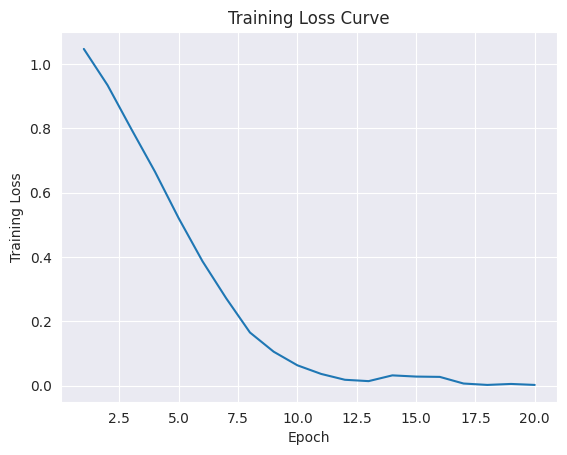

In [25]:
# If losses is a list of 20 loss values
plt.plot(range(1, len(losses) + 1), losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()
